<a href="https://colab.research.google.com/github/vindinudecosta/Mobile-Based-Crop-Leaf-Disease-Detection-System-Using-Deep-Learning/blob/main/Leaves_classificationTFlite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from zipfile import ZipFile
with ZipFile('/content/gdrive/MyDrive/leaves.zip','r') as zipObj:
     zipObj.extractall('leaves')

In [3]:
!pip install split-folders[full]

In [4]:
import splitfolders
input_folder = '/content/leaves/leaves'
splitfolders.ratio(input_folder,output ="dataset",
                   seed = 42,ratio=(0.7,0.1,0.2),
                   group_prefix=None)

Copying files: 21775 files [00:27, 778.73 files/s]


In [5]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator

In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 128
CHANNELS = 3
EPOCHS =10

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/leaves/leaves")

Found 21775 files belonging to 2 classes.


In [8]:
class_names = dataset.class_names
class_names

['Leaves', 'non leaves']

In [9]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    horizontal_flip= True,
    rotation_range=10)
train_generator = train_datagen.flow_from_directory('/content/dataset/train',

                                                    target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size= BATCH_SIZE,
                                                    class_mode='sparse',

                                                    )

Found 15241 images belonging to 2 classes.


In [10]:
validation_datagen = ImageDataGenerator(

                 rescale = 1./255,
                 horizontal_flip= True,
                 rotation_range =10

)

validation_generator = validation_datagen.flow_from_directory('/content/dataset/val',

                                                    target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size= BATCH_SIZE,
                                                    class_mode='sparse',

                                                    )

Found 2176 images belonging to 2 classes.


In [11]:
test_datagen = ImageDataGenerator(

                 rescale = 1./255,
                 horizontal_flip= True,
                 rotation_range =10

)

test_generator = test_datagen.flow_from_directory('/content/dataset/test',

                                                    target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='sparse',

                                                    )

Found 4358 images belonging to 2 classes.


In [19]:
input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes =2
base_model = tf.keras.applications.MobileNetV2(
    input_shape = input_shape,
    include_top=False,
    weights='imagenet',

)

for layer in base_model.layers:
    layer.trainable = False
#x = layers.Flatten()(x)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

In [23]:
model.compile(
  optimizer = 'RMSprop',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits =False),
  metrics = ['accuracy']

)

In [24]:
history = model.fit(

    train_generator,
    steps_per_epoch= 119,
    batch_size =BATCH_SIZE,
    validation_data= validation_generator,
    validation_steps =17,
    verbose=1,
    epochs =10
)

Epoch 1/10
119/119 [==============================] - 389s 3s/step - loss: 0.0237 - accuracy: 0.9891 - val_loss: 0.0035 - val_accuracy: 0.9977
Epoch 2/10
119/119 [==============================] - 379s 3s/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 9.5977e-04 - val_accuracy: 1.0000
Epoch 3/10
119/119 [==============================] - 409s 3s/step - loss: 1.7651e-04 - accuracy: 0.9999 - val_loss: 6.0573e-04 - val_accuracy: 1.0000
Epoch 4/10
119/119 [==============================] - 372s 3s/step - loss: 5.8885e-04 - accuracy: 0.9998 - val_loss: 0.0061 - val_accuracy: 0.9982
Epoch 5/10
119/119 [==============================] - 379s 3s/step - loss: 1.5127e-04 - accuracy: 0.9999 - val_loss: 5.3863e-04 - val_accuracy: 0.9995
Epoch 6/10
119/119 [==============================] - 375s 3s/step - loss: 5.9324e-05 - accuracy: 1.0000 - val_loss: 8.1034e-04 - val_accuracy: 0.9995
Epoch 7/10
119/119 [==============================] - 371s 3s/step - loss: 1.9497e-05 - accuracy: 1.0000 - val

In [25]:
scores = model.evaluate(test_generator,verbose=0)
scores

[0.0008559103007428348, 0.9995410442352295]

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

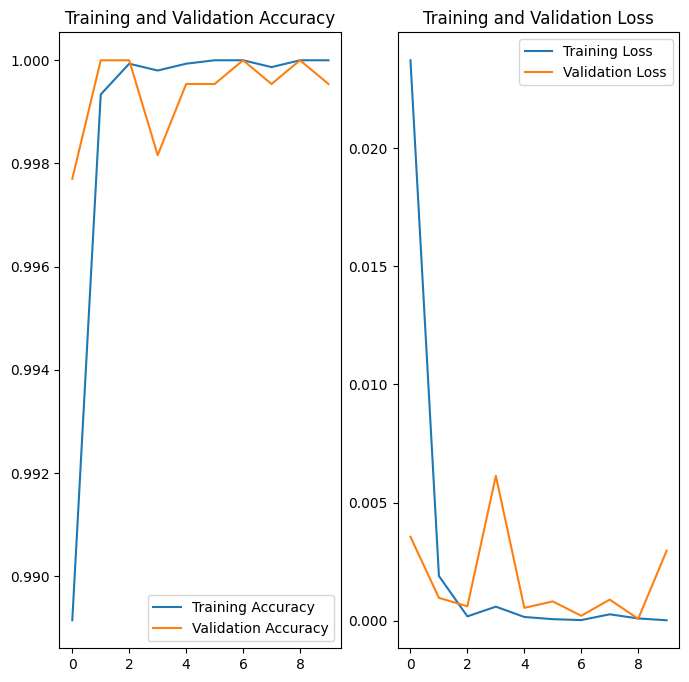

In [27]:
plt.figure(figsize =(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = 'Training Loss')
plt.plot(range(EPOCHS),val_loss,label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label:  non leaves
4/4 [==============================] - 2s 38ms/step
Predicted label:  non leaves


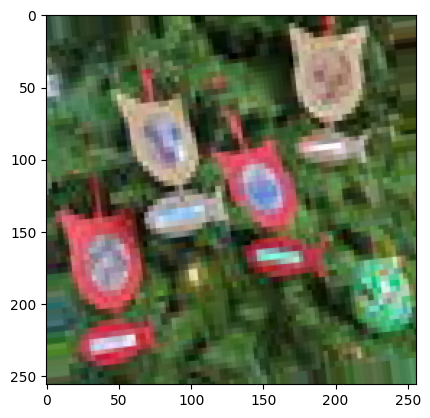

In [28]:
import numpy as np

for images_batch, labels_batch in test_generator:
  first_image = images_batch[0]
  first_label = int (labels_batch[0])

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label: ", class_names[first_label])


  batch_prediction = model.predict(images_batch)
  print("Predicted label: ",class_names[np.argmax(batch_prediction[0])])
  break

In [29]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i])
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100* (np.max(predictions[0])),2)

  return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


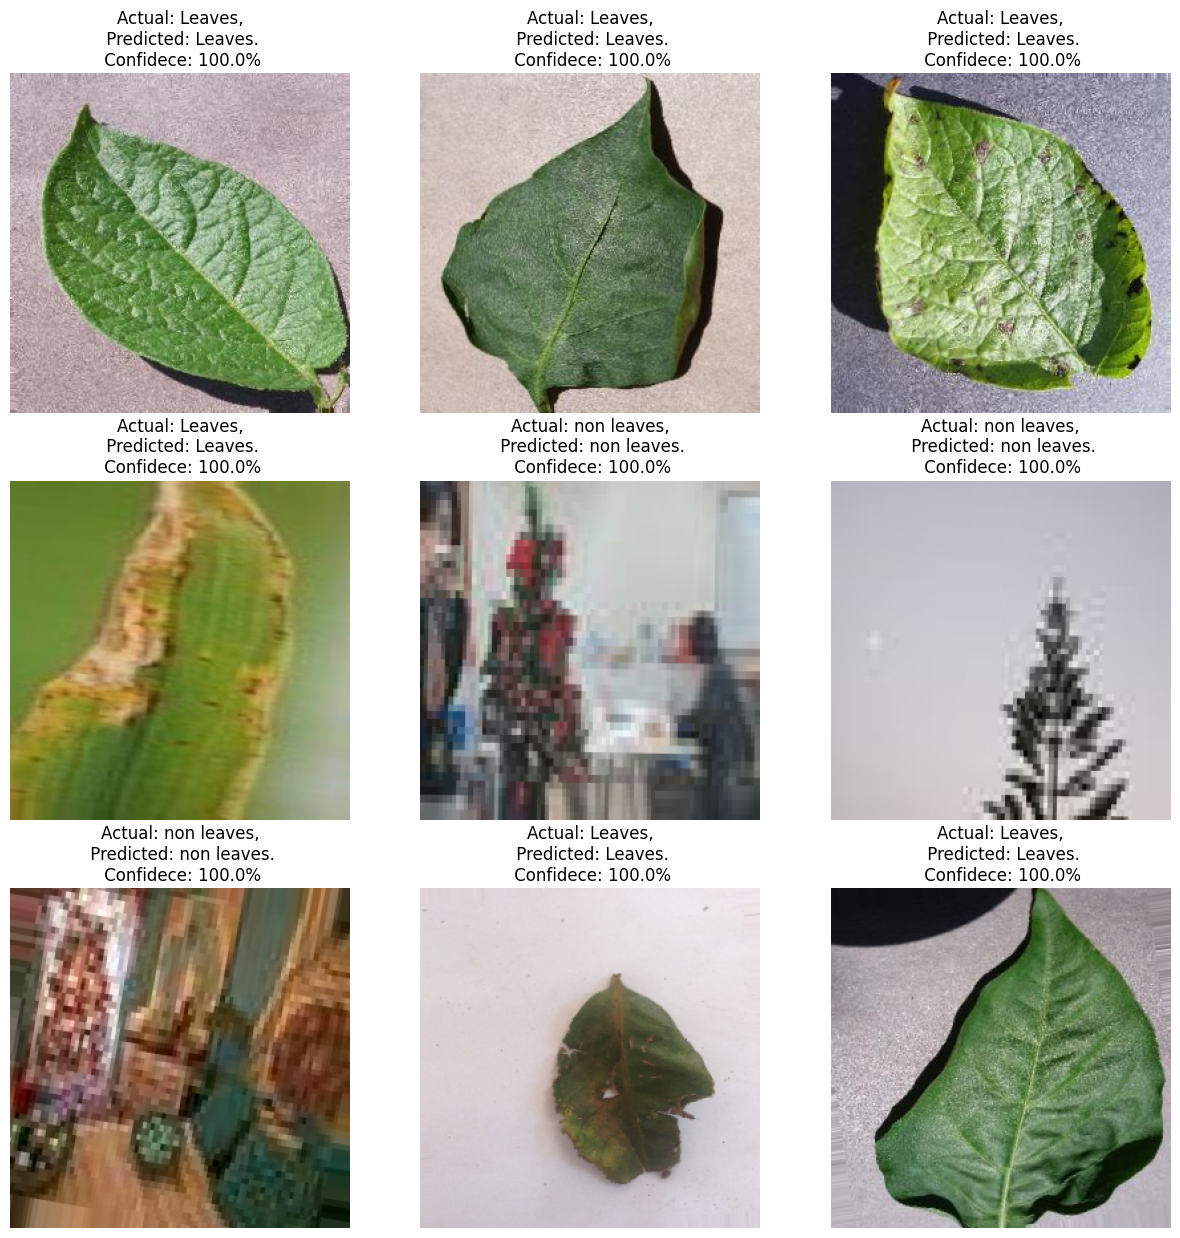

In [30]:
plt.figure(figsize = (15,15))
for images, labels in test_generator:

  for i in range(9):

    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i])

    predicted_class, confidence = predict(model, images[i])
    actual_class = class_names[int(labels[i])]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidece: {confidence}%")

    plt.axis("off")
  break

In [31]:
model.save("/content/gdrive/MyDrive/Rice_disease_classification_models/trained_model_leavesv1.h5")

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [33]:
with open('/content/gdrive/MyDrive/Rice_disease_classification_models/tflite_model_leaves_v1.tflite', 'wb') as f:
   f.write(tflite_quant_model)

In [34]:
import numpy
test_images = []
test_labels = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator[i]
    test_images.extend(batch_images)
    test_labels.extend(batch_labels)

# Convert the lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [35]:
def evaluate(interpreter):
  prediction= []
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  input_format = interpreter.get_output_details()[0]['dtype']

  for i, test_image in enumerate(test_images):
    if i % 100 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    test_image = np.expand_dims(test_image, axis=0).astype(input_format)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    prediction.append(predicted_label)

  print('\n')
  # Comparing prediction results with ground truth labels to calculate accuracy.
  prediction = np.array(prediction)
  accuracy = (prediction == test_labels).mean()
  return accuracy

In [38]:
# Passing the Integer Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('/content/gdrive/MyDrive/Rice_disease_classification_models/tflite_model_leaves_v1.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Quantized TFLite Model Test Accuracy:', test_accuracy*100)
##print('Baseline Keras Model Test Accuracy:', scores*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.
Evaluated on 1400 results so far.
Evaluated on 1500 results so far.
Evaluated on 1600 results so far.
Evaluated on 1700 results so far.
Evaluated on 1800 results so far.
Evaluated on 1900 results so far.
Evaluated on 2000 results so far.
Evaluated on 2100 results so far.
Evaluated on 2200 results so far.
Evaluated on 2300 results so far.
Evaluated on 2400 results so far.
Evaluated on 2500 results so far.
Evaluated on 2600 results so far.
Evaluated on 2700 results so far.
Evaluated on 2800 results so far.
Evaluated on 2900 results 